# Brazilian E-Commerce

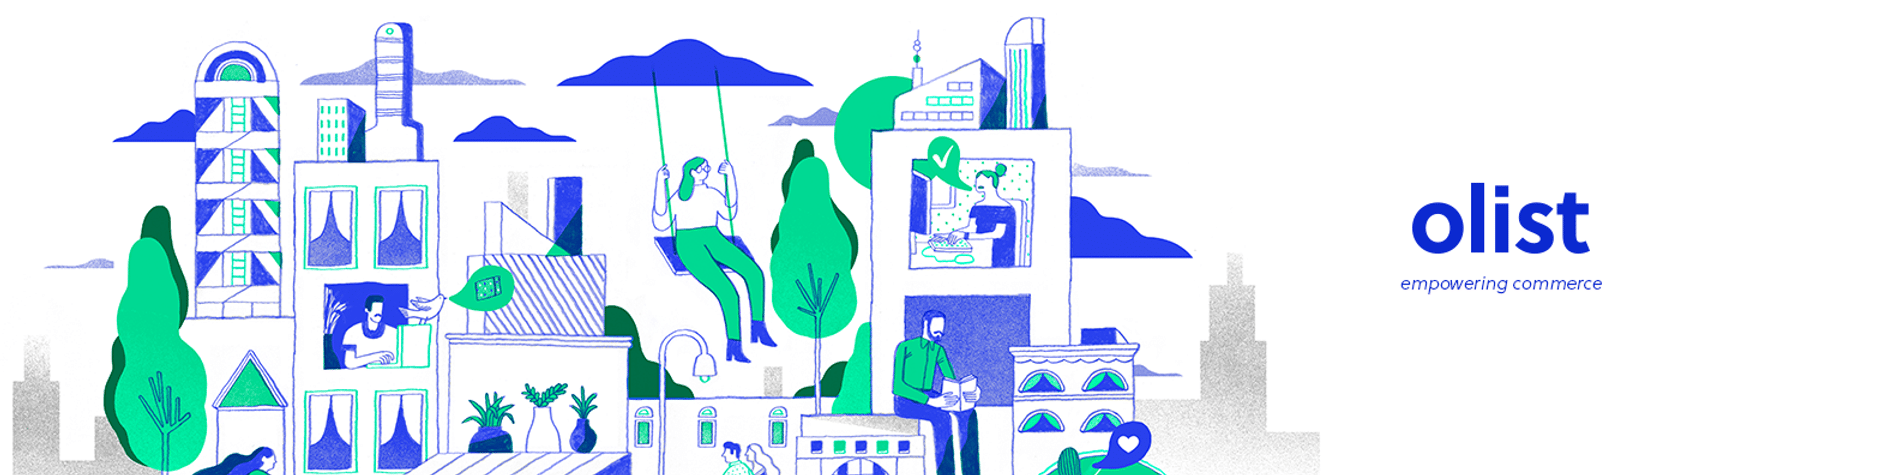

### 0. Загрузка датасетов и подготовка среды
### 1. Участники электронной торговли: продавцы и покупатели
### 2. Товары
### 3. Способы оплаты

### 0. Загрузка датасетов и подготовка среды

In [1]:
pip install plotly.express

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import date
from IPython.display import Image
import os

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_geolocation_dataset.csv
/kaggle/input/brazilian-ecommerce/product_category_name_translation.csv
/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv


In [4]:
path = r'/kaggle/input/brazilian-ecommerce/'
os.chdir(path)
sellers = pd.read_csv('olist_sellers_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
order_rev = pd.read_csv('olist_order_reviews_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')

orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_approved_at'] = pd.to_datetime(orders['order_approved_at'])
orders['order_del_car_date'] = pd.to_datetime(orders['order_delivered_carrier_date'])
orders['order_del_cust_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_est_del_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])

orders_items = pd.read_csv('olist_order_items_dataset.csv')
orders_pay = pd.read_csv('olist_order_payments_dataset.csv')
customers = pd.read_csv('olist_customers_dataset.csv')
transl = pd.read_csv('product_category_name_translation.csv')

products = products.merge(transl, left_on='product_category_name', right_on='product_category_name')

### 1. Участники электронной торговли: продавцы и покупатели

In [5]:
cust_order = customers.merge(orders, left_on='customer_id', right_on='customer_id')
cust_order = cust_order.merge(orders_pay, left_on='order_id', right_on='order_id')
cust_order['purchase_month'] = cust_order['order_purchase_timestamp'].astype('datetime64[M]')

top_cities = cust_order.groupby(['customer_city'])\
                    .agg({'payment_value':'sum'})\
                    .reset_index()\
                    .sort_values(by='payment_value', ascending=False)



percent = top_cities['payment_value'].sum()/100
top_cities.loc[top_cities['payment_value'] < percent, 'customer_city'] = 'Other cities' 
fig = px.pie(top_cities, values='payment_value', names='customer_city', title='Города с самым большим спросом e-com')
fig.show()

In [6]:
orders_geo = pd.read_csv('olist_geolocation_dataset.csv')

orders_geo = orders_geo.groupby(['geolocation_state','geolocation_city']).agg({'geolocation_lat':'mean',
                                                                               'geolocation_lng':'mean'}).reset_index()

fig = px.scatter_mapbox(orders_geo, lat="geolocation_lat", lon="geolocation_lng", 
                        hover_name="geolocation_city", hover_data=["geolocation_state"],
                      color_discrete_sequence=["darkblue"], zoom=3, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

<div class="alert alert-block alert-info">Длинная рука бразильской электронной коммерции дотянулась аж до Италии и Португалии.</div>

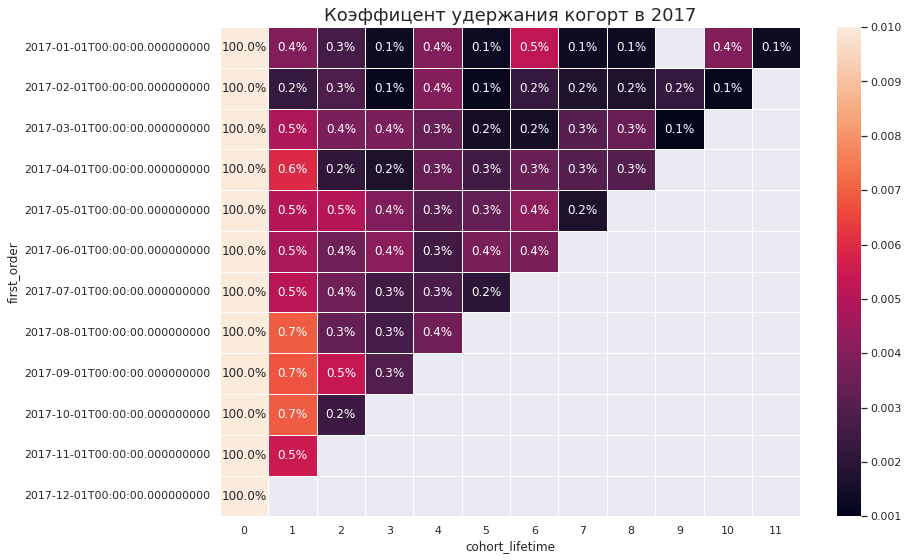

In [7]:
customer_grouped = orders.merge(customers, left_on='customer_id', right_on='customer_id')

first_orders = customer_grouped.groupby(['customer_unique_id'])['order_purchase_timestamp'].min()
first_orders.name = 'first_order'
customer_grouped = customer_grouped.join(first_orders, on='customer_unique_id')
#ограничим одним годом
customer_grouped = customer_grouped[(customer_grouped['order_purchase_timestamp'] > '2017-01-01 00:00:00')
                                    & (customer_grouped['order_purchase_timestamp'] < '2017-12-31 23:59:59')]

customer_grouped['first_order'] = customer_grouped['first_order'].astype('datetime64[M]')
customer_grouped['order_purchase_month'] = customer_grouped['order_purchase_timestamp'].astype('datetime64[M]')

customer_grouped["cohort_lifetime"] = customer_grouped['order_purchase_month'] - customer_grouped['first_order']
customer_grouped["cohort_lifetime"] = customer_grouped["cohort_lifetime"] / np.timedelta64(1,'M')
customer_grouped["cohort_lifetime"] = customer_grouped["cohort_lifetime"].round().astype('int')

cohorts = customer_grouped.groupby(["first_order", "cohort_lifetime"])\
        .agg({'customer_unique_id':"nunique"}).reset_index()

initial_users_count = cohorts[cohorts["cohort_lifetime"]== 0][["first_order", 'customer_unique_id']]

initial_users_count = initial_users_count.rename(columns={"customer_unique_id":"cohort_users"})

cohorts = cohorts.merge(initial_users_count, on="first_order")

cohorts['retention'] = cohorts['customer_unique_id'] / cohorts["cohort_users"]

retention_pivot = cohorts.pivot_table(index='first_order',
                                    columns='cohort_lifetime',
                                     values='retention',
                                     aggfunc='sum'
                                     )
sns.set(style='dark')
plt.figure(figsize=(13, 9))
plt.title('Коэффицент удержания когорт в 2017', fontsize=18)
sns.heatmap(retention_pivot, vmin=0.001, vmax=0.01, annot=True, fmt='.1%', linewidths=1, linecolor='white');


<div class="alert alert-block alert-info">На данной тепловой карте показан процент возврата пользователей, которые сделали первую покупку в месяце слева.</div>

In [8]:
seller_rating = orders_items[['order_id', 'seller_id']]\
    .merge(order_rev[['order_id', 'review_score']], left_on='order_id', right_on='order_id')\
    .groupby('seller_id').agg({'review_score':'mean', 'order_id':'count'}).reset_index()

fig = px.scatter(seller_rating, x="review_score", y="order_id", title='Зависимость количества заказов от рейтинга продавца',
                labels={'order_id': "Orders quantity", "review_score":'Seller average review score'})
fig.show()


### 2. Товары

In [9]:
product_rat = orders_items\
    .merge(products[['product_id', 'product_category_name_english']], on='product_id')\
    .groupby(['product_category_name_english']).agg({'order_id':'count'})\
    .reset_index()\
    .sort_values(by='order_id', ascending=False)

fig = px.bar(product_rat, x='product_category_name_english', y='order_id', width=900, height=700, 
             title='Количество проданных товаров', labels={'order_id':'product quantity', 'product_category_name_english':'Category name'})
fig.show()

In [10]:
product_rat = orders_items\
    .merge(products[['product_id', 'product_category_name_english']], on='product_id')\
    .groupby(['product_category_name_english']).agg({'price':'sum'})\
    .reset_index()\
    .sort_values(by='price', ascending=False)

fig = px.bar(product_rat, x='product_category_name_english', y='price', width=900, height=700, 
             title='Стоимость проданных товаров', labels={'price':'value', 'product_category_name_english':'Category name'})
fig.show()

In [11]:
product_rat = orders_items\
    .merge(products[['product_id', 'product_category_name_english']], on='product_id')\
    .groupby(['product_category_name_english']).agg({'price':'sum'})\
    .reset_index()\
    .sort_values(by='price', ascending=False)

top_cat = product_rat['product_category_name_english'].head(5)

orders['purchase_month'] = orders['order_purchase_timestamp'].astype('datetime64[M]')

products_top = products.query('product_category_name_english in @top_cat')

product_rat = orders_items\
    .merge(products_top[['product_id', 'product_category_name_english']], on='product_id')\
    .merge(orders, left_on='order_id', right_on='order_id')\
    .groupby(['product_category_name_english','purchase_month']).agg({'price':'sum'})\
    .reset_index()\
    .sort_values(by=['purchase_month', 'product_category_name_english'], ascending=False)


fig = px.line(product_rat, x="purchase_month", y="price", color='product_category_name_english', 
              labels={'purchase_month': "Order Month", 'price': 'Value', 'product_category_name_english':'Product'},
                     title='Динамика продаж топ-5 категорий')
fig.show()

### 3. Способы оплаты

In [12]:
fig = px.histogram(orders_pay, x="payment_type", title='Использование платежных систем по количеству операций',
                   labels={'payment_type': 'Payment type'})
fig.show()

fig = px.pie(orders_pay, values='payment_value', names='payment_type', 
             title='Использование платежных систем по сумме покупок')
fig.show()

In [13]:
orders_pay_dt = orders_pay.merge(orders, left_on='order_id', right_on='order_id')

orders_pay_dt['month_purchase'] = orders_pay_dt['order_purchase_timestamp'].astype('datetime64[M]')

grouped_payments = orders_pay_dt.groupby(['month_purchase', 'payment_type']).agg({'payment_value':'sum'}).reset_index()


fig = px.line(grouped_payments, x="month_purchase", y="payment_value", color='payment_type', 
              labels={'month_purchase': "Order Month", 'payment_value': 'Payment value', 'payment_type':'Payment type'},
                     title='Совокупные покупки по типам платежа', color_discrete_sequence= px.colors.sequential.Plasma_r)
fig.show()

<div class="alert alert-block alert-info">В Бразилии самый настоящий бум покупок на кредитку. Красиво жить не запретишь, тем более в долг.</div>